In [123]:
import pandas as pd
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import openmeteo_requests
import requests_cache
from retry_requests import retry
import requests

# Part 1: Download and Format Data

In [124]:
#Pipeline Data
ngtl_m = pd.read_csv('NGTL_Gas_Day.csv')

# Set the DataFrame's column names to be the values of the first row 
ngtl_m.columns = ngtl_m.iloc[0]

# Drop the first row of the DataFrame 
ngtl_m = ngtl_m.drop(ngtl_m.index[0])

# Reset the DataFrame's index to be zero-based again, and ensure the old index is not added as a column in the DataFrame
ngtl_m.reset_index(drop=True, inplace=True)

# Selecting specific columns using index positions
ngtl_m = ngtl_m.iloc[:, [0, 8]]

# Converting 'Gas Day' column to datetime
ngtl_m['Gas Day'] = pd.to_datetime(ngtl_m['Gas Day'])

# Sorting DataFrame by 'Gas Day'
ngtl_m = ngtl_m.sort_values(by='Gas Day')

#Convert Intraprovincial to float64
ngtl_m['Intraprovincial'] = pd.to_numeric(ngtl_m['Intraprovincial'], errors='coerce')


ngtl_m['Intraprovincial'] = -1.0 * ngtl_m['Intraprovincial']


ngtl_d = pd.read_excel('NGTL_data_from_dad.xlsx')

# Calculating a new column and adjusting its units
ngtl_d["Intra Provincial Deliveries Volume (103M3)"] = (ngtl_d["Intra Provincial Deliveries Volume (103M3)"] - ngtl_d["Storage Deliveries Volume (103M3)"]) / 1000.0

# Selecting specific columns and renaming one of them
ngtl_d = ngtl_d[['Gas Day', "Intra Provincial Deliveries Volume (103M3)"]]
ngtl_d.rename(columns={"Intra Provincial Deliveries Volume (103M3)": 'Intraprovincial'}, inplace=True)

# Converting 'Gas Day' column to datetime
ngtl_d['Gas Day'] = pd.to_datetime(ngtl_d['Gas Day'])

# Concatenate the two DataFrames vertically
gas_df = pd.concat([ngtl_d, ngtl_m])

# Drop duplicates based on the 'Gas Day' column, keeping the last occurrence
gas_df = gas_df.drop_duplicates(subset='Gas Day', keep='last')

# Reset the index of the concatenated DataFrame
gas_df.reset_index(drop=True, inplace=True)

# Print the concatenated DataFrame
print(gas_df)

        Gas Day  Intraprovincial
0    2016-01-01         151.6124
1    2016-01-02         157.5868
2    2016-01-03         156.9401
3    2016-01-04         160.3902
4    2016-01-05         163.2315
...         ...              ...
3195 2024-09-29         156.7000
3196 2024-09-30         160.0000
3197 2024-10-01         161.2000
3198 2024-10-02         169.8000
3199 2024-10-03         168.2000

[3200 rows x 2 columns]


In [206]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 51.05,
    "longitude": -114.07,
	"start_date": "2014-08-23",
	"end_date": "2024-10-04",
	"daily": ["temperature_2m_max", "temperature_2m_min", "apparent_temperature_max", "apparent_temperature_min"]
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()
daily_temperature_2m_min = daily.Variables(1).ValuesAsNumpy()
daily_apparent_temperature_max = daily.Variables(2).ValuesAsNumpy()
daily_apparent_temperature_min = daily.Variables(3).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}
daily_data["temperature_2m_max"] = daily_temperature_2m_max
daily_data["temperature_2m_min"] = daily_temperature_2m_min
daily_data["apparent_temperature_max"] = daily_apparent_temperature_max
daily_data["apparent_temperature_min"] = daily_apparent_temperature_min

daily_dataframe = pd.DataFrame(data = daily_data)

daily_dataframe['date'] = daily_dataframe['date'].dt.tz_localize(None)

print(daily_dataframe)


Coordinates 51.07205581665039°N -114.03227233886719°E
Elevation 1049.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
           date  temperature_2m_max  temperature_2m_min  \
0    2014-08-23           13.524500              5.7245   
1    2014-08-24           15.724500              6.3745   
2    2014-08-25           20.074501              5.7745   
3    2014-08-26           24.374500              8.5245   
4    2014-08-27           26.724501             10.9245   
...         ...                 ...                 ...   
3691 2024-09-30           13.660000              1.0600   
3692 2024-10-01           16.410000              5.4100   
3693 2024-10-02           14.960000              2.2100   
3694 2024-10-03           12.760000              0.2100   
3695 2024-10-04           11.710000             11.7100   

      apparent_temperature_max  apparent_temperature_min  
0                    11.572901                  4.127649  
1                    13.540415              

In [207]:
#Match the dates
common_dates = set(gas_df['Gas Day']).intersection(daily_dataframe['date'])

# Size of rolling average
size = 1

# Filter each DataFrame to include only the common dates
Y = gas_df[gas_df['Gas Day'].isin(common_dates)]
X = daily_dataframe[daily_dataframe['date'].isin(common_dates)]

Y.set_index('Gas Day', inplace=True)
X.set_index('date', inplace=True)

Y.loc[:, 'YesterdayDemand'] = Y['Intraprovincial'].rolling(window=size, min_periods=1).mean().shift(1)
Y = Y.reset_index()
Y.rename(columns={'Gas Day': 'date'}, inplace=True)

X = X.merge(Y[['date', 'YesterdayDemand']], on='date', how='left')
Y = Y[['date','Intraprovincial']]

Y.set_index('date', inplace=True)
X.set_index('date', inplace=True)

Y = Y.iloc[1:]
X = X.iloc[1:]

print(X)
# Seperate Data to Train Model
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=20)

            temperature_2m_max  temperature_2m_min  apparent_temperature_max  \
date                                                                           
2016-01-02           -1.725500          -19.675499                 -6.779565   
2016-01-03           -4.375500          -17.075499                 -9.217386   
2016-01-04           -1.625500          -13.775500                 -5.144395   
2016-01-05           -6.675500          -13.075500                -10.939353   
2016-01-06           -8.975500          -18.175499                -13.389229   
...                        ...                 ...                       ...   
2024-09-29           17.309999            6.560000                 13.301954   
2024-09-30           13.660000            1.060000                  7.812244   
2024-10-01           16.410000            5.410000                 13.082935   
2024-10-02           14.960000            2.210000                 11.906919   
2024-10-03           12.760000          

C:\Users\gingi\AppData\Local\Temp\ipykernel_15512\1461846136.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y.loc[:, 'YesterdayDemand'] = Y['Intraprovincial'].rolling(window=size, min_periods=1).mean().shift(1)


# Part 2: Creating The Model

MSE with scikit-learn: 21.00322921084784
R-squared (R²) with scikit-learn: 0.9697652177230928


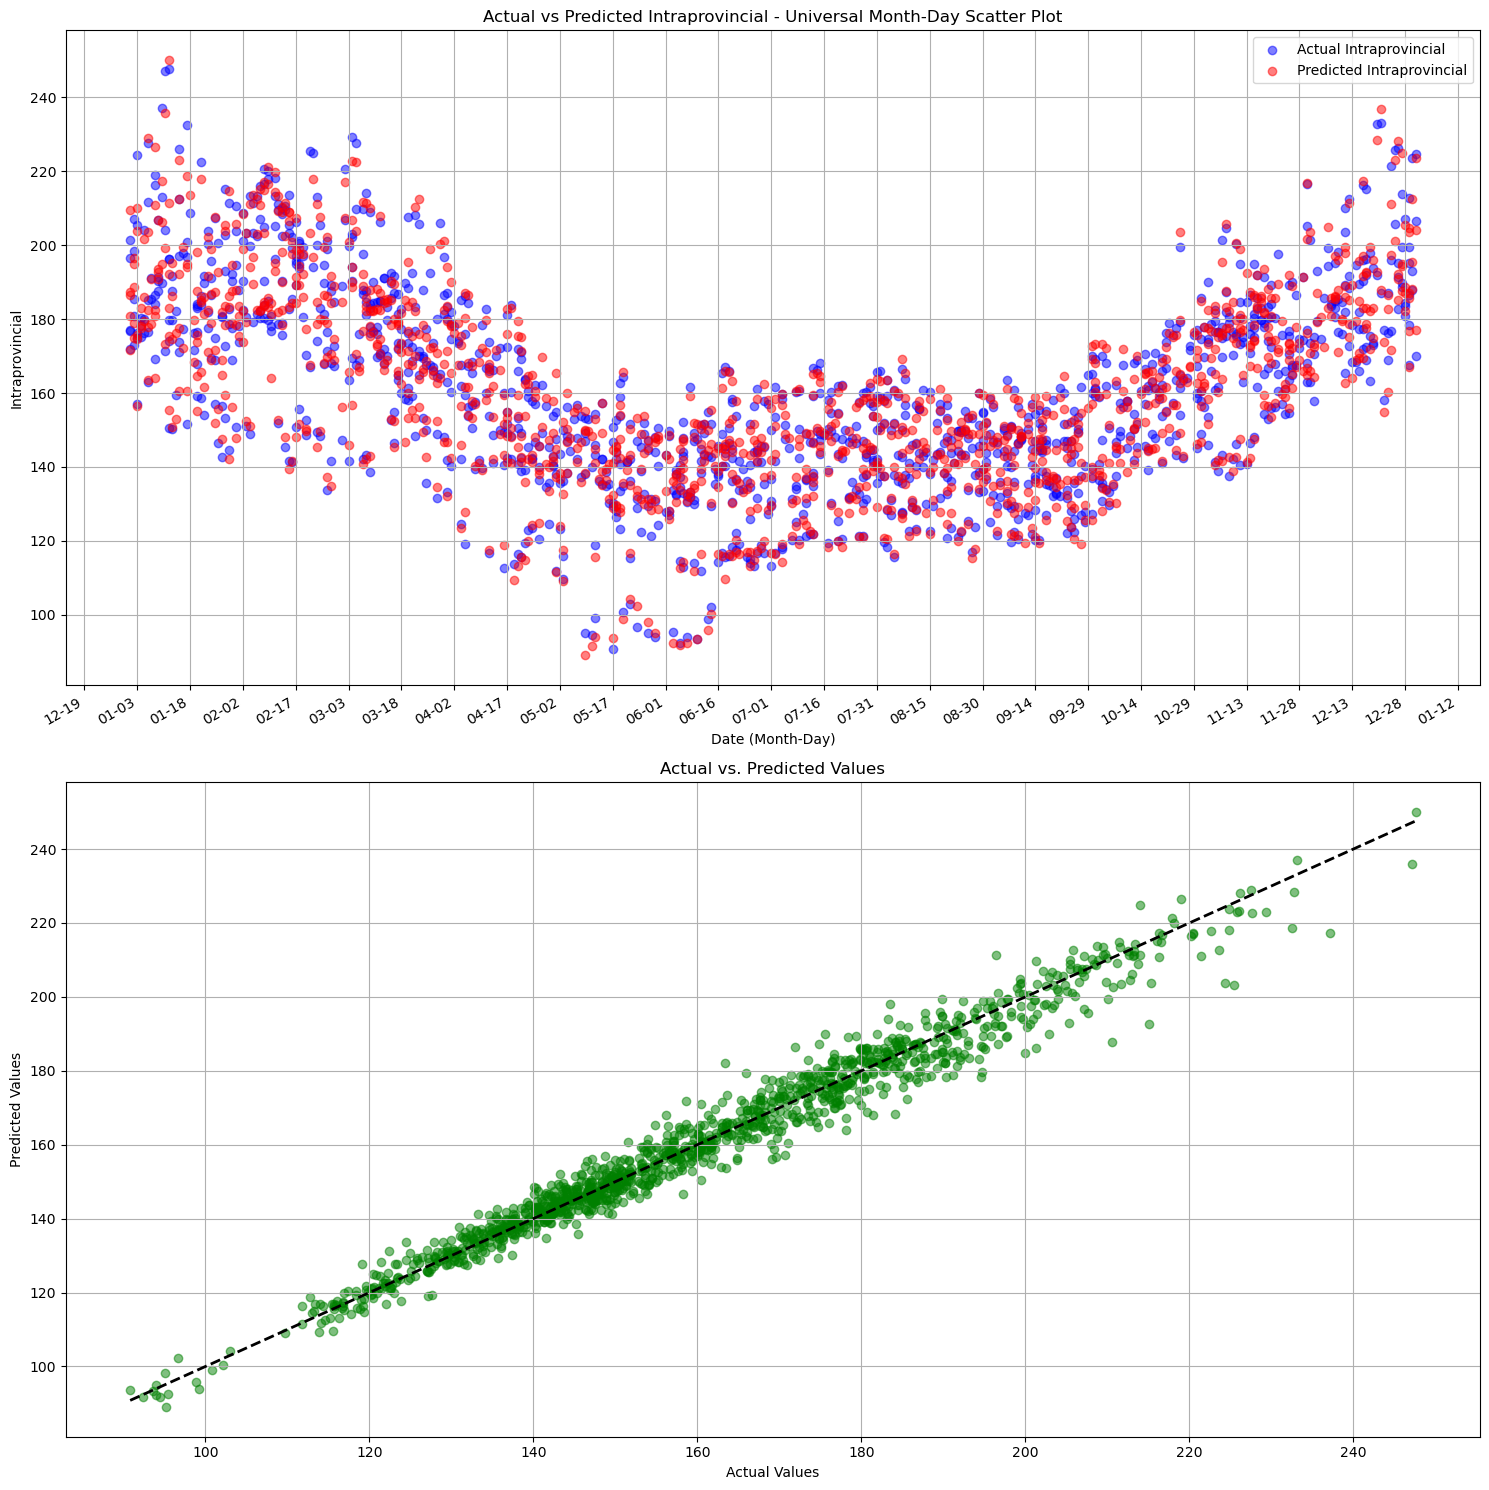

In [221]:
# Degree of the polynomial features
degree = 3

# Create a pipeline that first transforms the data to polynomial features, then fits a linear model
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(X_train, Y_train)

# Predict and flatten to 1D
predictions = model.predict(X_test).flatten()

# Convert predictions to a pandas Series with a modified index for the first plot
predictions_series = pd.Series(predictions, index=Y_test.index.map(lambda d: d.replace(year=2000)))
Y_test.index = Y_test.index.map(lambda d: d.replace(year=2000))

# Calculate MSE and R²
mse = mean_squared_error(Y_test, predictions_series)
r_squared = r2_score(Y_test, predictions_series)

print("MSE with scikit-learn:", mse)
print("R-squared (R²) with scikit-learn:", r_squared)
    
# Plotting setup
plt.figure(figsize=(15, 15))

# First subplot for time-series comparison with modified date indices
plt.subplot(2, 1, 1)  # 1 row, 2 columns, 1st subplot
plt.scatter(Y_test.index, Y_test, label='Actual Intraprovincial', color='blue', alpha=0.5)
plt.scatter(predictions_series.index, predictions_series, label='Predicted Intraprovincial', color='red', alpha=0.5)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
plt.gcf().autofmt_xdate()
plt.title('Actual vs Predicted Intraprovincial - Universal Month-Day Scatter Plot')
plt.xlabel('Date (Month-Day)')
plt.ylabel('Intraprovincial')
plt.legend()
plt.grid(True)

# Second subplot for scatter plot of predicted vs. actual values
plt.subplot(2, 1, 2)  # 1 row, 2 columns, 2nd subplot
plt.scatter(Y_test, predictions_series, alpha=0.5, color='green')  # Use the same data but reformat as needed
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=2)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)

plt.tight_layout()
# Show the combined plots
plt.show()

# Part 3: Forecast Demand

In [222]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://api.open-meteo.com/v1/forecast"
params = {
    "latitude": 51.05,
    "longitude": -114.07,
    "daily": ["temperature_2m_max", "temperature_2m_min", "apparent_temperature_max", "apparent_temperature_min"]
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()
daily_temperature_2m_min = daily.Variables(1).ValuesAsNumpy()
daily_apparent_temperature_max = daily.Variables(2).ValuesAsNumpy()
daily_apparent_temperature_min = daily.Variables(3).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}
daily_data["temperature_2m_max"] = daily_temperature_2m_max
daily_data["temperature_2m_min"] = daily_temperature_2m_min
daily_data["apparent_temperature_max"] = daily_apparent_temperature_max
daily_data["apparent_temperature_min"] = daily_apparent_temperature_min

frc_dataframe = pd.DataFrame(data = daily_data)

frc_dataframe['date'] = frc_dataframe['date'].dt.tz_localize(None)

print(frc_dataframe)


Coordinates 51.054447174072266°N -114.07634735107422°E
Elevation 1049.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
        date  temperature_2m_max  temperature_2m_min  \
0 2024-10-05           16.093000            4.543000   
1 2024-10-06           15.443000            6.993000   
2 2024-10-07           21.506001            6.706000   
3 2024-10-08           22.106001           10.506001   
4 2024-10-09           19.406000            6.606000   
5 2024-10-10           21.556000           12.106000   
6 2024-10-11           15.406000            7.806000   

   apparent_temperature_max  apparent_temperature_min  
0                 11.100791                  0.627507  
1                 12.617064                  3.610039  
2                 19.466736                  3.952164  
3                 18.207083                  6.946364  
4                 16.641891                  3.652317  
5                 18.743216                  8.977374  
6                 11.460140  

In [223]:
# Step 1: Get today's data from daily_dataframe
today = daily_dataframe[daily_dataframe['date'] == pd.to_datetime('2024-10-04')]

# Step 2: Get 'Intraprovincial' data from gas_df for both today and yesterday
# Ensure gas_df has datetime format for the 'Gas Day' column
gas_df['Gas Day'] = pd.to_datetime(gas_df['Gas Day'])

# Get intraprovincial data for '2024-10-03'
intraprovincial_yesterday = gas_df[gas_df['Gas Day'] == pd.to_datetime('2024-10-03')]

# Add 'Intraprovincial' for today's data and set 'YesterdayDemand' to yesterday's demand
if not intraprovincial_yesterday.empty:
    # Extract the 'Intraprovincial' value for yesterday
    rolling_avg_value = intraprovincial_yesterday['Intraprovincial'].values[0]
    today['YesterdayDemand'] = rolling_avg_value
else:
    # If no data for yesterday, assign NaN
    today['YesterdayDemand'] = pd.NA

# Step 3: Add today's data to the forecasted dataframe
toforecast = pd.concat([today, frc_dataframe]).reset_index(drop=True)

toforecast['date'] == pd.to_datetime(toforecast['date'])
# Print the updated frc_dataframe
print(toforecast)

        date  temperature_2m_max  temperature_2m_min  \
0 2024-10-04           11.710000           11.710000   
1 2024-10-05           16.093000            4.543000   
2 2024-10-06           15.443000            6.993000   
3 2024-10-07           21.506001            6.706000   
4 2024-10-08           22.106001           10.506001   
5 2024-10-09           19.406000            6.606000   
6 2024-10-10           21.556000           12.106000   
7 2024-10-11           15.406000            7.806000   

   apparent_temperature_max  apparent_temperature_min  YesterdayDemand  
0                  7.438312                  7.438312            168.2  
1                 11.100791                  0.627507              NaN  
2                 12.617064                  3.610039              NaN  
3                 19.466736                  3.952164              NaN  
4                 18.207083                  6.946364              NaN  
5                 16.641891                  3.652317    

C:\Users\gingi\AppData\Local\Temp\ipykernel_15512\2061252292.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  today['YesterdayDemand'] = rolling_avg_value


In [224]:
# Ensure that 'date' column is in datetime format
toforecast['date'] = pd.to_datetime(toforecast['date'])

# Initialize an empty list to store the dates and predictions
demand_data = []

# Iterate over each row in toforecast
for i in range(len(toforecast)):
    # Get the current date
    current_date = toforecast.loc[i, 'date']

    # Extract data for the current date to make a prediction
    data_for_prediction = toforecast[toforecast['date'] == current_date]

    # Ensure the extracted data is not empty
    if not data_for_prediction.empty:
        # Drop the 'date' column to create the feature set for prediction
        X_to_predict = data_for_prediction.drop(columns=['date'])

        # Make a prediction using the trained model
        prediction = model.predict(X_to_predict).flatten()[0]

        # Append the current date and prediction to the demand_data list
        demand_data.append({'date': current_date, 'frc_demand': prediction})

        # Update 'YesterdayDemand' for the next day if it's not the last row
        if i < len(toforecast) - 1:
            next_date_index = i + 1
            toforecast.loc[next_date_index, 'YesterdayDemand'] = prediction

# Create a new DataFrame from the collected demand data
forecast = pd.DataFrame(demand_data)

# Print the updated forecast DataFrame
print("Forecast DataFrame:")
print(forecast)

Forecast DataFrame:
        date  frc_demand
0 2024-10-04  169.784807
1 2024-10-05  168.584046
2 2024-10-06  169.375273
3 2024-10-07  166.313735
4 2024-10-08  165.217405
5 2024-10-09  163.829264
6 2024-10-10  164.380801
7 2024-10-11  166.767570


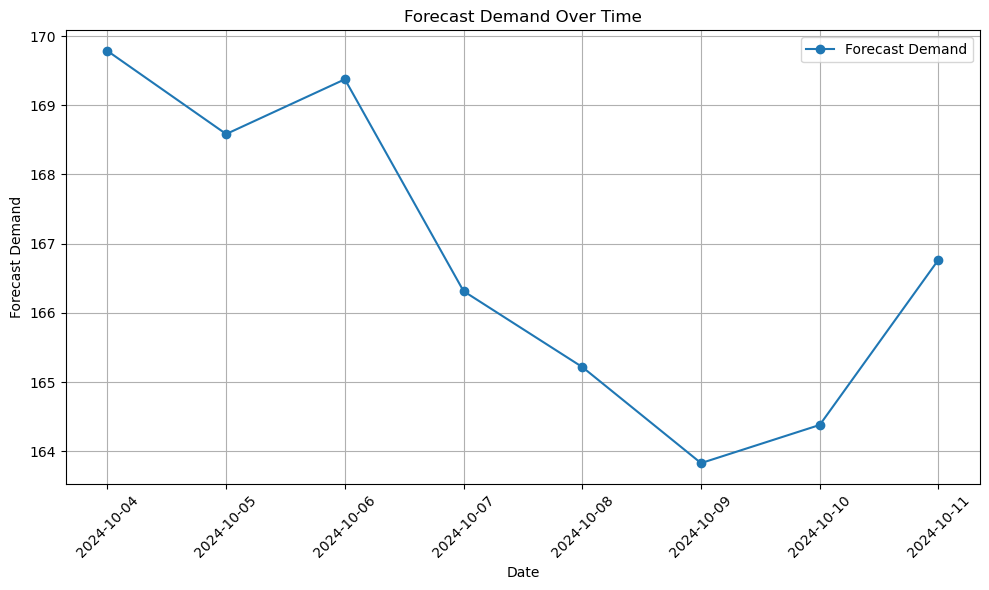

In [225]:
# Assuming 'forecast' DataFrame already exists
# Ensure the 'date' column is in datetime format
forecast['date'] = pd.to_datetime(forecast['date'])

# Plot the line graph
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(forecast['date'], forecast['frc_demand'], marker='o', linestyle='-', label='Forecast Demand')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Forecast Demand')
plt.title('Forecast Demand Over Time')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)           # Add a grid to the graph
plt.legend()             # Add a legend to the graph

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

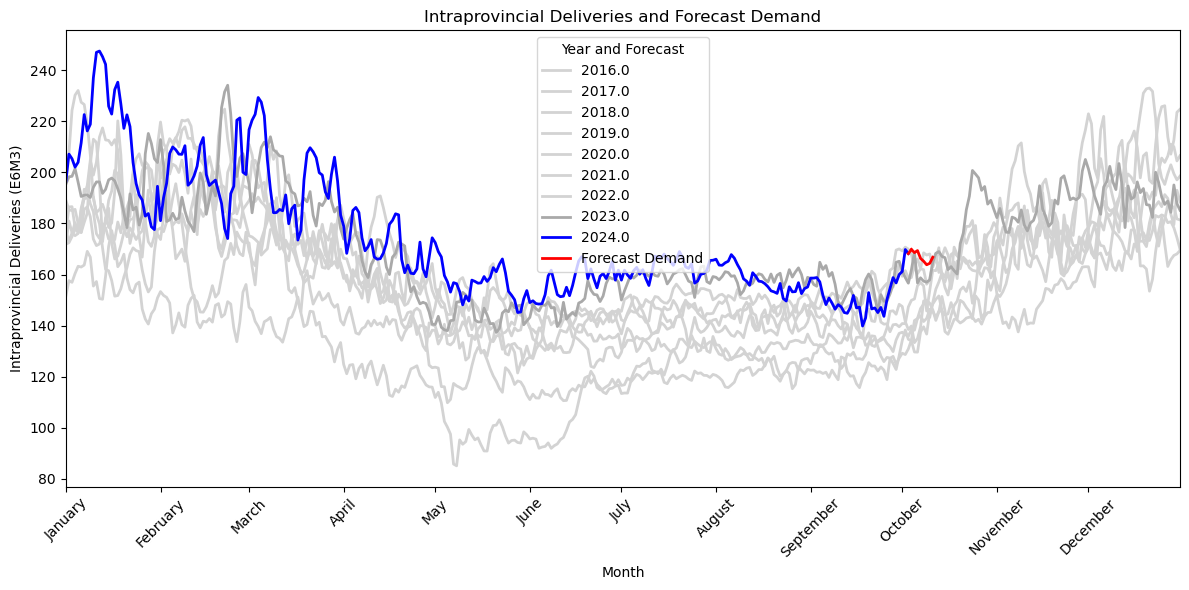

In [226]:
# Create a new DataFrame called 'graph1' as a copy of 'forecast'
graph1 = forecast.copy()

# Convert 'Gas Day' and 'date' columns to datetime format
gas_df['Gas Day'] = pd.to_datetime(gas_df['Gas Day'])
graph1['date'] = pd.to_datetime(graph1['date'])

# Rename 'date' column in graph1 to match 'Gas Day' in gas_df so they can be combined
graph1.rename(columns={'date': 'Gas Day', 'frc_demand': 'Intraprovincial'}, inplace=True)

# Add a column to distinguish forecast data
graph1['is_forecast'] = True
gas_df['is_forecast'] = False  # Add column to distinguish historical data

# Add graph1 data to gas_df
combined_df = pd.concat([gas_df, graph1], ignore_index=True)

# Remove all columns except 'Gas Day', 'Intraprovincial', and 'is_forecast'
combined_df = combined_df[['Gas Day', 'Intraprovincial', 'is_forecast']]

# Create a 'month_day' column with the same year for all dates to facilitate yearly comparison
combined_df['month_day'] = combined_df['Gas Day'].apply(lambda x: x.replace(year=2000))

# Extract year information for color differentiation
combined_df['year'] = combined_df['Gas Day'].dt.year

# Plot the data for combined_df
plt.figure(figsize=(12, 6))

# Plot the historical data from combined_df with different colors by year
for year, group in combined_df[combined_df['is_forecast'] == False].groupby('year'):
    plt.plot(group['month_day'], group['Intraprovincial'], label=str(year), color='blue' if year == 2024 else 'darkgray' if year == 2023 else 'lightgray', linewidth=2)

# Plot the forecast data in red, ensuring it is connected to historical data
forecast_data = combined_df[combined_df['is_forecast'] == True]
plt.plot(forecast_data['month_day'], forecast_data['Intraprovincial'], linestyle='-', color='red', label='Forecast Demand', linewidth=2)

# Plot the last historical point and the first forecast point to connect the line
last_historical_date = combined_df[(combined_df['is_forecast'] == False)].iloc[-1]
first_forecast_date = forecast_data.iloc[0]

# Plot the connecting line between the last historical point and first forecast point
plt.plot(
    [last_historical_date['month_day'], first_forecast_date['month_day']],
    [last_historical_date['Intraprovincial'], first_forecast_date['Intraprovincial']],
    linestyle='-', color='red', linewidth=2
)

# Set x-axis labels to show the name of the month on the first of every month
month_starts = pd.date_range(start='2000-01-01', end='2000-12-31', freq='MS')
month_names = month_starts.strftime('%B')
plt.xticks(month_starts, month_names, rotation=45)

# Extend x-axis limits to make the graph touch the sides of the frame
plt.xlim(pd.Timestamp('2000-01-01'), pd.Timestamp('2000-12-31'))

# Set labels and title
plt.xlabel('Month')
plt.ylabel('Intraprovincial Deliveries (E6M3)')
plt.title('Intraprovincial Deliveries and Forecast Demand')
plt.legend(title='Year and Forecast')
plt.tight_layout()

# Show the plot
plt.show()

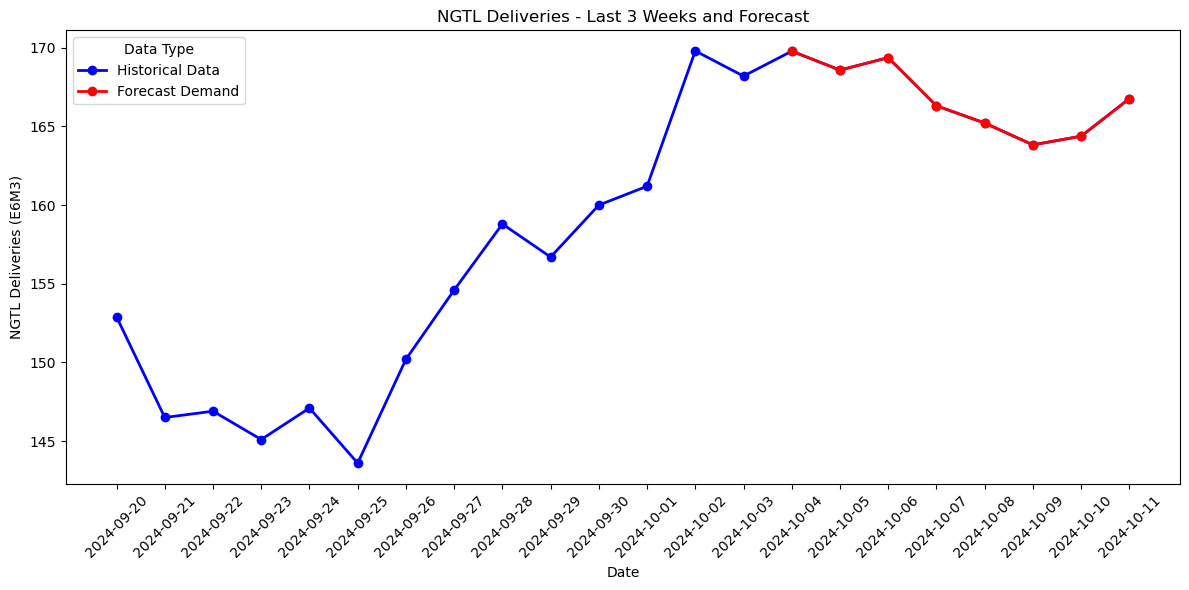

In [227]:
# Create a new DataFrame called 'graph2' as a copy of 'forecast'
graph2 = forecast.copy()

# Convert 'Gas Day' and 'date' columns to datetime format
gas_df['Gas Day'] = pd.to_datetime(gas_df['Gas Day'])
graph2['date'] = pd.to_datetime(graph2['date'])

# Rename 'date' column in graph2 to match 'Gas Day' in gas_df so they can be combined
graph2.rename(columns={'date': 'Gas Day', 'frc_demand': 'Intraprovincial'}, inplace=True)

# Add a column to distinguish forecast data
graph2['is_forecast'] = True
gas_df['is_forecast'] = False  # Add column to distinguish historical data

# Add graph2 data to gas_df
combined_df = pd.concat([gas_df, graph2], ignore_index=True)

# Remove all columns except 'Gas Day', 'Intraprovincial', and 'is_forecast'
combined_df = combined_df[['Gas Day', 'Intraprovincial', 'is_forecast']]

# Filter combined_df to get only the last 3 weeks of historical data plus the forecast
last_date = combined_df['Gas Day'].max()
three_weeks_ago = last_date - pd.Timedelta(weeks=3)
filtered_df = combined_df[(combined_df['Gas Day'] >= three_weeks_ago) | (combined_df['is_forecast'] == True)]

# Plot the data for filtered_df
plt.figure(figsize=(12, 6))

# Plot both historical and forecast data as a continuous line
plt.plot(filtered_df['Gas Day'], filtered_df['Intraprovincial'], marker='o', linestyle='-', color='blue', linewidth=2, label='Historical Data')

# Highlight the forecasted points in red
forecast_data = filtered_df[filtered_df['is_forecast'] == True]
plt.plot(forecast_data['Gas Day'], forecast_data['Intraprovincial'], marker='o', linestyle='-', color='red', linewidth=2, label='Forecast Demand')

# Set x-axis labels to display each date individually
plt.xticks(filtered_df['Gas Day'], filtered_df['Gas Day'].dt.strftime('%Y-%m-%d'), rotation=45)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('NGTL Deliveries (E6M3)')
plt.title('NGTL Deliveries - Last 3 Weeks and Forecast')
plt.legend(title='Data Type')
plt.tight_layout()

# Show the plot
plt.show()